In [5]:
from pckgs.headline_preprocess import HeadlinePreprocess

import pandas as pd
from pckgs.helper import timeseries_to_supervised, evaluate
import matplotlib.pyplot as plt
import seaborn as sb
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM, Dropout, Conv2D, MaxPooling2D,Reshape
from tensorflow.keras.optimizers import Adam, SGD
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
#read headline vectors and shape them correctly
df = pd.read_csv('./datasets/headline_vectors_mean.csv', index_col='date', parse_dates=['date'])
# create shifted observations and reshape to 3d input
lag = 21  # 20+1 so we don't use headlines from same day (leakage)
future = 5 #this needs to change...use reindex!!!!!!!!!!!!!!!!!!!!!!!!
x = HeadlinePreprocess.shape_vectors(df, lag, future)

               0_t-1     0_t-2     0_t-3     0_t-4     0_t-5     0_t-6  \
date                                                                     
2013-04-22  0.014687  0.014687  0.014687  0.002857  0.062277  0.023672   
2013-04-23  0.022953  0.014687  0.014687  0.014687  0.002857  0.062277   
2013-04-24  0.025516  0.022953  0.014687  0.014687  0.014687  0.002857   
2013-04-25  0.017946  0.025516  0.022953  0.014687  0.014687  0.014687   
2013-04-26  0.032302  0.017946  0.025516  0.022953  0.014687  0.014687   

               0_t-7     0_t-8     0_t-9    0_t-10  ...  299_t-11  299_t-12  \
date                                                ...                       
2013-04-22  0.059543 -0.017587 -0.017587  0.016005  ...  0.042496  0.042496   
2013-04-23  0.023672  0.059543 -0.017587 -0.017587  ...  0.042496  0.042496   
2013-04-24  0.062277  0.023672  0.059543 -0.017587  ... -0.001197  0.042496   
2013-04-25  0.002857  0.062277  0.023672  0.059543  ... -0.001197 -0.001197   
2013-04

In [8]:
# get y
df = pd.read_csv('../Price/datasets/bitcoin_position_day_20_thres1.csv', header=0, parse_dates=['Timestamp'], index_col='Timestamp')
y = df.loc[:, ['down', 'same', 'up']]
print(y.head())
print(y.shape)

            down  same  up
Timestamp                 
2013-04-22     0     0   1
2013-04-23     0     0   1
2013-04-24     0     1   0
2013-04-25     1     0   0
2013-04-26     1     0   0
(2441, 3)


In [9]:
#split train, test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)

print(x_train.shape)
print(y_train.shape)
print(y_test.value_counts())

index = y_test.index

(1952, 20, 300)
(1952, 3)
down  same  up
0     1     0     208
1     0     0     142
0     0     1     139
dtype: int64


In [10]:
#read candle and align with input
df_candle = pd.read_csv('../Price/datasets/bitcoin_candle_day.csv', header=0, parse_dates=['Timestamp'], index_col='Timestamp')
df_candle.rename(columns={'Open': 'open', 'Low': 'low', 'High': 'high', 'Close': 'close'}, inplace=True)
df_candle.index.rename('date', inplace=True)
# align dates
df_candle = df_candle.loc[(df_candle.index >= index[0]) &
                          (df_candle.index <= index[len(y_test) - 1])]
print(df_candle)

               open     high      low    close
date                                          
2018-08-26  6732.99  6775.34  6558.95  6700.46
2018-08-27  6700.13  6944.47  6641.35  6904.51
2018-08-28  6911.70  7125.28  6861.17  7080.94
2018-08-29  7079.46  7124.06  6890.00  7032.96
2018-08-30  7034.47  7055.97  6792.85  6984.01
...             ...      ...      ...      ...
2019-12-23  7521.88  7692.98  7247.86  7316.17
2019-12-24  7317.47  7431.10  7156.00  7251.52
2019-12-25  7247.45  7266.81  7110.73  7195.79
2019-12-26  7195.80  7432.00  7150.00  7188.30
2019-12-27  7195.17  7255.37  7052.00  7246.00

[489 rows x 4 columns]


In [11]:
#create labeled y_test to measure pnl, confusion matrix
y_test.index.rename('date', inplace=True)
y_test_labeled = y_test.rename(columns={'down': -1, 'same': 0, 'up': 1})
y_test_labeled = y_test_labeled.idxmax(axis=1)
print(y_test_labeled)

date
2018-08-26    1
2018-08-27    1
2018-08-28    1
2018-08-29    0
2018-08-30    0
             ..
2019-12-23   -1
2019-12-24    0
2019-12-25    0
2019-12-26    0
2019-12-27    0
Length: 489, dtype: int64


In [87]:
#2D CONVOLUTION
model = Sequential()
for i in range(1):
    model.add(Reshape((20, 300, 1), input_shape=(20,300)))
    model.add(Conv2D(filters=64,
                      kernel_size = (3,300),
                      activation='relu'))
    model.add(MaxPooling2D((3,1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 20, 300, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 1, 64)         57664     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                19250     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 153       
Total params: 77,067
Trainable params: 77,067
Non-trainable params: 0
__________________________________________________

In [23]:
#2D CONVOLUTION-LSTM DOC2VEC
model = Sequential()
for i in range(1):
    model.add(Reshape((20, 300, 1), input_shape=(20,300)))
    model.add(Conv2D(filters=32,
                      kernel_size = (3,300),
                      activation='relu'))
    model.add(MaxPooling2D((3,1)))
model.add(Reshape((6, 32)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 20, 300, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 18, 1, 32)         28832     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 1, 32)          0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 6, 32)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 45,585
Trainable params: 45,585
Non-trainable params: 0
__________________________________________________

In [24]:
from pckgs.helper import PnlCallback

# es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.001, verbose=1, patience=50)
# mc = ModelCheckpoint('headline_model.h5',verbose=1, save_best_only=True)
pnl = PnlCallback(x_test, df_candle)

history = model.fit(x=x_train, y=y_train, validation_data=(x_test, y_test),
                    batch_size=64, epochs=400, verbose=1, callbacks=[pnl], shuffle=False)

model = load_model('headline_model.h5')

Epoch 1/400
29/31 [===========================>..] - ETA: 0s - loss: 1.0990 - accuracy: 0.3346
 Pnl improved, current pnl is:  0.06619348907394786

 Pnl has not improved since  0  epoch
31/31 [==============================] - 1s 31ms/step - loss: 1.0989 - accuracy: 0.3330 - val_loss: 1.0986 - val_accuracy: 0.2843
Epoch 2/400
31/31 [==============================] - 0s 10ms/step - loss: 1.0982 - accuracy: 0.3724 - val_loss: 1.0985 - val_accuracy: 0.2843

<AxesSubplot:>

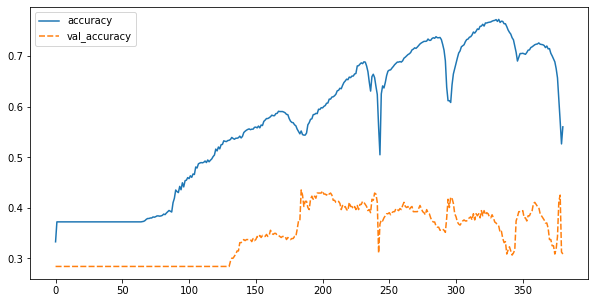

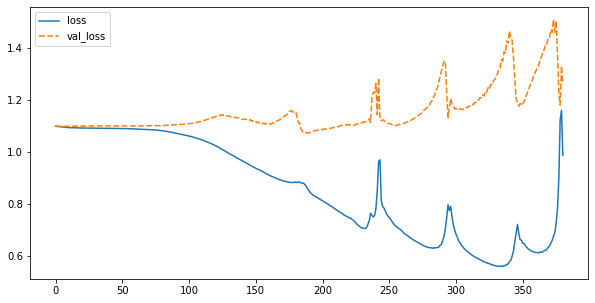

In [25]:
ac = {'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}
plt.figure(figsize=(10,5))
sb.lineplot(data=ac)

loss = {'loss': history.history['loss'], 'val_loss': history.history['val_loss']}
plt.figure(figsize=(10,5))
sb.lineplot(data=loss)

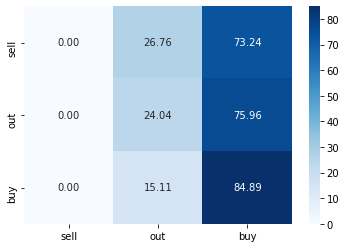

In [26]:
#create labeled y_pred for pnl, confusion matrix
y_pred = model.predict(x_test)
y_pred_labeled = pd.DataFrame(y_pred, columns=[-1, 0, 1], index=index)
y_pred_labeled = y_pred_labeled.idxmax(axis=1)


from pckgs.evaluator import Evaluator
Evaluator.evaluate(y_pred_labeled, y_test_labeled, df_candle)
